# Using Neural Networks to Detect Sarcasm in News Headlines

In this project, I will be building a simple neural network to predict whether a news headline is sarcastic or truthful. The data was pulled from <a href="https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json">this Kaggle dataset</a> from Rishabh Misra.

Each record consists of three attributes:

- `is_sarcastic`: 1 if the record is sarcastic otherwise 0

- `headline`: the headline of the news article

- `article_link`: link to the original news article. Useful for collecting supplementary data

From Misra:

<i>Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.</i>

<i>To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.</i>

<i>This new dataset has following advantages over the existing Twitter datasets:</i>

<i>Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.</i>

<i>Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.</i>

<i>Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.</i>

We can begin by importing and parsing the JSON data.

## Importing and Parsing the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.feature_extraction.text import TfidfVectorizer
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError as mse
import sklearn.metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score, recall_score

In [4]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('data/Sarcasm_Headlines_Dataset.json'))

In [26]:
df = pd.DataFrame(data)
df.rename(columns={"article_link":"link"}, inplace=True)

## Exploratory Data Analysis

In [25]:
df.head()

,link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [27]:
df.tail()

,link,headline,is_sarcastic
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0
26708,https://www.huffingtonpost.com/entry/gourmet-g...,gourmet gifts for the foodie 2014,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


Dataset appears to have 26,709 rows and 3 (non-null) columns. Let's see if there are an equal number of sarcastic and non-sarcastic tweets, as having an overrepresentation in one or the other could lead to a poorer model.

<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

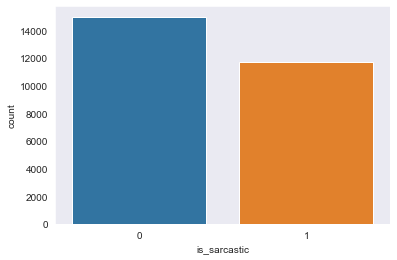

In [41]:
sns.set_style("dark")

sns.countplot(x="is_sarcastic", data=df)

We see there are slightly more non-sarcastic tweets. We can use `.value_counts()` to get a closer approximation:

In [42]:
df["is_sarcastic"].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

## Splitting into Train/Test Sets

We will use the `TfidVectorizer` in order to vectorize words from each headline into our `X`.

In [11]:
#creating the X variable
vectorizer = TfidfVectorizer(max_features=50, use_idf=False)
headlines = [i['headline'] for i in data]
X = vectorizer.fit_transform(headlines).toarray()

#Creating our y variable
y = np.ravel([i['is_sarcastic'] for i in data])

#Creating a train and test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 1)

## Building the Neural Network

We will use Keras `Sequential()` in order to the build the neural network. I'll choose to add 3 hidden layers with the softmax activiation function, and then an output layer with the sigmoid activation function.

In [16]:
# initialize the model
model = Sequential()

#Add the input layer
model.add(Dense(24, activation = 'softmax', input_shape = (50,)))

#Add first hidden layer
model.add(Dense(12, activation = 'softmax'))

#Add second hidden layer
model.add(Dense(8, activation = 'softmax'))

#Add third hidden layer
model.add(Dense(4, activation = 'softmax'))

#Add output layer
model.add(Dense(1, activation='sigmoid'))

We'll then compile the model using a loss function of binary cross-entropy and the `adam` optimizer. We'll fit the model with 10 epochs and a batch size of 200.

In [22]:
#compiling the model
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy', 'mse'])

#fit the model
model.fit(X_train, y_train, epochs = 10,
          batch_size = 200, verbose = 1)

Epoch 1/10
107/107 [==============================] - 1s 778us/step - loss: 0.6911 - accuracy: 0.5254 - mse: 0.2490
Epoch 2/10
107/107 [==============================] - 0s 778us/step - loss: 0.6858 - accuracy: 0.5612 - mse: 0.2463
Epoch 3/10
107/107 [==============================] - 0s 829us/step - loss: 0.6874 - accuracy: 0.5535 - mse: 0.2471
Epoch 4/10
107/107 [==============================] - 0s 766us/step - loss: 0.6851 - accuracy: 0.5629 - mse: 0.2460
Epoch 5/10
107/107 [==============================] - 0s 774us/step - loss: 0.6867 - accuracy: 0.5548 - mse: 0.2468
Epoch 6/10
107/107 [==============================] - 0s 779us/step - loss: 0.6823 - accuracy: 0.5664 - mse: 0.2446
Epoch 7/10
107/107 [==============================] - 0s 795us/step - loss: 0.6786 - accuracy: 0.5547 - mse: 0.2428
Epoch 8/10
107/107 [==============================] - 0s 775us/step - loss: 0.6570 - accuracy: 0.5796 - mse: 0.2322
Epoch 9/10
107/107 [==============================] - 0s 784us/step - lo

## Testing the Model Against the Test Set

In [23]:
#rounding each prediction of the X_test set
y_pred = np.around(model.predict(X_test))

#evaluating accuracy, precision, and recall
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

167/167 [==============================] - 0s 489us/step - loss: 0.5789 - accuracy: 0.7070 - mse: 0.1958
[0.5789444446563721, 0.7070385813713074, 0.1958429366350174]
Precision: 0.6287281453548166
Recall: 0.7918825561312608


We'll also print out a confusion matrix.

In [24]:
matrix = cm(y_test, y_pred)
df = pd.DataFrame(columns = ['', 'is_sarcastic', 'not_sarcastic'])
df.loc[len(df)] = ['is_sarcastic', matrix[0][0], matrix[0][1]]
df.loc[len(df)] = ['not_sarcastic', matrix[1][0], matrix[1][1]]
print(df)

                 is_sarcastic not_sarcastic
0   is_sarcastic         1943          1083
1  not_sarcastic          482          1834
